In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [3]:
from src.utils import *
from experiments.data_utils import *
from experiments.plot_utils import *
from experiments.hyperparam_tuning import *
from sklearn.model_selection import cross_val_score


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
target = 'performance' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision
model = 'svm' # lr, svm, mlp, rf, xgb
feature_type = 'traditional' # traditional, bow

In [5]:
output_dir = 'experiments/results'

In [6]:
data_map = {}

data_map['traditional'] = {
    'bugbug_buglevel': lambda target: get_ml_data_traditional('bugbug', target, kind='buglevel'),
    'bugbug_szz': lambda target: get_ml_data_traditional('bugbug_szz', target, kind='commitlevel'),
    'fixed_defect_szz': lambda target: get_ml_data_traditional('fixed_defect_szz', target, kind='commitlevel')
}
data_map['bow'] = {
    'bugbug_buglevel': lambda target: get_ml_data_bow('bugbug', target, kind='buglevel'),
    'bugbug_szz': lambda target: get_ml_data_bow('bugbug_szz', target, kind='commitlevel'),
    'fixed_defect_szz': lambda target: get_ml_data_bow('fixed_defect_szz', target, kind='commitlevel')
}

In [7]:
def get_results(data, feature_type, target, scoring, model):
    path = os.path.join(output_dir, f'{data}_{feature_type}_{target}_{scoring}_{model}.csv')
    results = pd.read_csv(path, index_col=0)
    results = results.replace({np.nan: None})
    return results
results = get_results(data, feature_type, target, scoring, model)
results

,param_kernel__degree,param_kernel__kernel,param_model,param_model__C,param_sampler,mean_fit_time,std_fit_time,mean_test_score,std_test_score,rank_test_score
67,5,rbf,LinearSVC,1.503715,SMOTE(random_state=0),14.219721,2.829093,0.080390,0.034392,1
17,3,rbf,LinearSVC,3.111710,SMOTE(random_state=0),24.640040,4.327267,0.080027,0.034981,2
66,5,rbf,LinearSVC,1.354004,SMOTE(random_state=0),13.121517,2.387203,0.079950,0.034467,3
32,3,rbf,LinearSVC,1.266582,SMOTE(random_state=0),13.266593,3.035038,0.079584,0.034095,4
25,3,rbf,LinearSVC,0.958611,SMOTE(random_state=0),10.761792,2.143430,0.079214,0.033758,5
...,...,...,...,...,...,...,...,...,...,...
62,5,poly,LinearSVC,0.000100,RandomUnderSampler(random_state=0),0.470724,0.087680,0.052510,0.020164,96
29,3,rbf,LinearSVC,0.000106,SMOTE(random_state=0),2.969741,0.424546,0.052365,0.020327,97
46,3,rbf,LinearSVC,0.000100,RandomOverSampler(random_state=0),3.004475,0.455885,0.052301,0.021325,98
15,3,rbf,LinearSVC,0.000107,None,1.879631,0.234783,0.051466,0.030982,99


In [8]:
X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)



In [9]:
def get_params(results):
    params = results[[c for c in results.columns if 'param' in c]]
    params = params.rename(lambda c: c[6:], axis=1) # remove param_
    return params
params = get_params(results)

In [10]:
from sklearn.dummy import DummyClassifier

model_map = {
    'dummy': lambda: DummyClassifier(constant=1),
    'lr': lambda: LogisticRegression(random_state=0, solver='saga'),
    'svm': lambda: LinearSVC(random_state=0),
    'mlp': lambda: MLPClassifier(random_state=0),
    'rf': lambda: RandomForestClassifier(random_state=0),
    'xgb': lambda: xgboost.XGBClassifier(random_state=0, n_jobs=4, use_label_encoder=False, eval_metric='logloss')
}
model_names = {
    'dummy': 'Dummy Classifier',
    'lr': 'Logistic Regression',
    'svm': 'Support Vector Machine',
    'rf': 'Random Forest',
    'xgb': 'XGBoost',
    'mlp': 'Multi-Layer Perceptron',
    'tpot': 'TPOT'
}
models = list(model_names.keys())

In [11]:
def get_best_params(model, params):
    best_params = dict(params.iloc[0])

    best_params['model'] = model_map[model]()
    try:
        best_params['sampler'] = eval(best_params['sampler'])
    except:
        best_params['sampler'] = None
    
    return best_params

best_params = get_best_params(model, params)
best_params

{'kernel__degree': 5,
 'kernel__kernel': 'rbf',
 'model': LinearSVC(random_state=0),
 'model__C': 1.5037148200199555,
 'sampler': SMOTE(random_state=0)}

In [12]:
pipeline = default_pipeline() if model != 'svm' else svm_pipeline()
pipeline.set_params(**best_params)
pipeline

Pipeline(steps=[('scaler', MinMaxScaler()), ('sampler', SMOTE(random_state=0)),
                ('kernel',
                 Nystroem(degree=5, n_components=500, random_state=0)),
                ('model', LinearSVC(C=1.5037148200199555, random_state=0))])

In [13]:
results.iloc[0]

param_kernel__degree                        5
param_kernel__kernel                      rbf
param_model                         LinearSVC
param_model__C                       1.503715
param_sampler           SMOTE(random_state=0)
mean_fit_time                       14.219721
std_fit_time                         2.829093
mean_test_score                       0.08039
std_test_score                       0.034392
rank_test_score                             1
Name: 67, dtype: object

In [14]:
def get_best_f1_threshold(clf, X, y):
    y_score = get_y_score(clf, X)
    precision, recall, thresholds = metrics.precision_recall_curve(y, y_score)
    precision = precision[:-1] # last one is 0
    recall = recall[:-1] # last one is 1

    D = precision + recall
    P = precision[D != 0]
    R = recall[D != 0]
    F1 = 2 * P * R / D[D != 0]
    T = thresholds[D != 0]

    amax = F1.argmax()
    return T[amax], F1[amax]

In [15]:
def get_tpot_pipeline(data, feature_type, target, scoring):
    import re
    from tpot.export_utils import set_param_recursive
    path = os.path.join(output_dir, f'{data}_{feature_type}_{target}_{scoring}_tpot_exported_pipeline.py')

    with open(path,'r') as f:
        exported_pipeline_str = f.read()
        import_lines = []
        pipeline_lines = []
        state = 0
        for line in exported_pipeline_str.splitlines():
            if len(line) == 0:
                continue
            if line[0] == '#':
                state += 1
                continue
                
            if state == 0:
                import_lines.append(line)
            if state == 2:
                pipeline_lines.append(line)

        import_statements = '\n'.join(import_lines)
        exec(import_statements)
        pipeline_statements = '\n'.join(pipeline_lines)

        exported_pipeline = eval(pipeline_statements[20:]) 
        set_param_recursive(exported_pipeline.steps, 'random_state', 0)

        score = float(re.findall('Average CV score on the training set was: ([\d.]+)', exported_pipeline_str)[0])
        return exported_pipeline, None, score


In [282]:
def get_pipeline(data, feature_type, target, scoring, model):
    if model == 'dummy':
        return model_map[model](), None, None
    if model == 'tpot':
        return get_tpot_pipeline(data, feature_type, target, scoring)
        
    results = get_results(data, feature_type, target, scoring, model)
    best_result = results.iloc[0]
    params = get_params(results)
    best_params = get_best_params(model, params)

    pipeline = default_pipeline() if model != 'svm' else svm_pipeline()
    pipeline.set_params(**best_params)
    if feature_type == 'bow':
        pipeline.set_params(scaler=None)

    return pipeline, best_params, best_result['mean_test_score']

from sklearn.model_selection import cross_validate
def evaluate_pipeline(model, target, data, feature_type, scoring, X_train, y_train, X_test, y_test):
    evaluation = {'model': model}

    pipeline, best_params, best_result = get_pipeline(data, feature_type, target, scoring, model)

    y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
    tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
    res = cross_validate(pipeline, X_train, y_train, scoring=['average_precision', 'roc_auc'], cv=tscv, n_jobs=5)
    evaluation['validation'] = res
    
    pipeline.fit(X_train, y_train)
    evaluation['fitted_pipeline'] = pipeline
    evaluation['best_params'] = best_params
    evaluation['best_result'] = best_result

    threshold_train, f1_train = get_best_f1_threshold(pipeline, X_train, y_train)
    threshold_test, f1_test = get_best_f1_threshold(pipeline, X_test, y_test)
    print(f'{threshold_train=} {f1_train=}, {threshold_test=}, {f1_test=}')

    for (split, X_, y_, threshold) in [
        ('train', X_train, y_train, threshold_train),
        ('test', X_test, y_test, threshold_train),
        ('test_pareto', X_test, y_test, threshold_test)
        ]:

        y_score = get_y_score(pipeline, X_)
        y_pred = y_score >= threshold

        evaluation[split] = {
            'average_precision': metrics.average_precision_score(y_, y_score),
            'roc_auc': metrics.roc_auc_score(y_, y_score),

            'threshold': threshold,
            
            'regression': {
                'recall': metrics.recall_score(y_, y_pred, pos_label=1),
                'precision': metrics.precision_score(y_, y_pred, pos_label=1, zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, pos_label=1)
            },
            'non-regression': {
                'recall': metrics.recall_score(y_, y_pred, pos_label=0),
                'precision': metrics.precision_score(y_, y_pred, pos_label=0, zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, pos_label=0)
            },
            'avg_weighted': {
                'recall': metrics.recall_score(y_, y_pred, average='weighted'),
                'precision': metrics.precision_score(y_, y_pred, average='weighted', zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, average='weighted')
            },
            'avg_macro': {
                'recall': metrics.recall_score(y_, y_pred, average='macro'),
                'precision': metrics.precision_score(y_, y_pred, average='macro', zero_division=0),
                'f1': metrics.f1_score(y_, y_pred, average='macro')
            }
        }

    
    return evaluation

def evaluate_pipelines(target, data, feature_type, scoring, X_train, y_train, X_test, y_test):
    evaluations = []
    for model in models:
        print(model)
        try:
            evaluation = evaluate_pipeline(model, target, data, feature_type, scoring, X_train, y_train, X_test, y_test)
            evaluations.append(evaluation)
        except Exception as e:
            print(e)

    return evaluations


In [17]:
def get_overfit_stat_df(evaluation):
    columns = [
        np.array(['train', 'train', 'validation', 'validation', 'test', 'test']),
        np.array(['Avg. Precision', 'AUC', 'Avg. Precision', 'AUC', 'Avg. Precision', 'AUC']),
    ]

    df = pd.DataFrame([[
        evaluation['train']['average_precision'],
        evaluation['train']['roc_auc'],
        evaluation['validation']['test_average_precision'].mean(),
        evaluation['validation']['test_roc_auc'].mean(),
        evaluation['test']['average_precision'],
        evaluation['test']['roc_auc']
        ]],
        index=[model_names[evaluation['model']]],
        columns=columns)
    return df

In [18]:
def get_classification_report_df(evaluation):
    dfs = []
    for split in ['train', 'test', 'test_pareto']:
        df = pd.DataFrame(
            [
                evaluation[split]['regression'],
                evaluation[split]['non-regression'],
                evaluation[split]['avg_macro'],
                evaluation[split]['avg_weighted']
            ],
            index=[
                [model_names[evaluation['model']]]*4,
                ['regression', 'non-regression', 'weighted average', 'micro average']
                ]
        )
        df.columns = [
            np.array([split]*3),
            np.array(['recall', 'precision', 'F1'])
        ]
        dfs.append(df)

    classification_reports = pd.concat(dfs, axis=1)

    return classification_reports

In [357]:
from matplotlib.lines import Line2D
def plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    fitted_pipelines, X_train, X_test, y_train, y_test, split='test', save=False, figsize=(12,8), ylim=[0,1]):

    if split == 'test':
        _X = X_test
        _y = y_test
    elif split == 'train':
        _X = X_train
        _y = y_train

    roc_fig, roc_ax = plt.subplots(figsize=figsize)
    roc_ax.axline([0,0], [1,1], color='black', linestyle='dashed')
    roc_ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')

    pr_fig, pr_ax = plt.subplots(figsize=figsize)
    pr_ax.set_ylim(ylim)
    R, P = np.meshgrid(np.linspace(0,1,100), np.linspace(ylim[0], ylim[1],100))
    F1 = 2 * R * P / (R + P)
    CS = pr_ax.contour(R, P, F1, levels=np.arange(0.1, 1, 0.1), alpha=0.5, colors='gray')
    pr_ax.clabel(CS, CS.levels, inline=1)
    random_guess_precision = _y.sum() / len(_y)
    pr_ax.axline([0,random_guess_precision], [1,random_guess_precision], color='black', linestyle='dashed')
    pr_ax.set(xlabel='Recall', ylabel='Precision', title='Recall-Precision Curve')

    for (model, pipeline) in fitted_pipelines:
        y_score = get_y_score(pipeline, _X)

        fpr, tpr, thresholds = metrics.roc_curve(_y, y_score)
        roc_ax.plot(fpr, tpr, label=model)

        precision, recall, thresholds = metrics.precision_recall_curve(_y, y_score)
        pr_ax.plot(recall, precision, label=model)

        # marking best threshold
        # threshold_train, f1_train = get_best_f1_threshold(pipeline, X_train, y_train)
        # y_score = get_y_score(pipeline, _X)
        # y_pred = y_score >= threshold_train

        # R = metrics.recall_score(_y, y_pred)
        # P =  metrics.precision_score(_y, y_pred)
        
        #pr_ax.plot([R, R], [0, P], linestyle="dashed", color=plt.gca().lines[-1].get_color(), linewidth=1)
        #pr_ax.plot([0, R], [P, P], linestyle="dashed", color=plt.gca().lines[-1].get_color(), linewidth=1)
        # pr_ax.annotate("",
        #     xy=(R, 0), xycoords='data',
        #     xytext=(R, -0.1*(ylim[1]-ylim[0])), textcoords='data',
        #     arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color=plt.gca().lines[-1].get_color()),
        #     )
        # pr_ax.annotate("",
        #     xy=(0, P), xycoords='data',
        #     xytext=(-0.03, P), textcoords='data',
        #     arrowprops=dict(arrowstyle="-", connectionstyle="arc3", color=plt.gca().lines[-1].get_color()),
        #     )

    random_line = Line2D([0], [0], label='Random guessing', color='black', linestyle='dashed')

    handles, _ = roc_ax.get_legend_handles_labels() 
    handles.append(random_line)
    roc_ax.legend(handles=handles)

    
    handles, _ = pr_ax.get_legend_handles_labels()  
    f1_line = Line2D([0], [0], label='F1 isolines', color='gray', alpha=0.5)
    handles.extend([random_line, f1_line])
    pr_ax.legend(handles=handles)

    roc_fig.tight_layout()
    if save:
        roc_fig.savefig(f'experiments/plots/{data}_{feature_type}_{target}_{scoring}_roc_{split}.pdf')

    pr_fig.tight_layout()
    if save:
        pr_fig.savefig(f'experiments/plots/{data}_{feature_type}_{target}_{scoring}_pr_{split}.pdf')
    plt.show()


In [ ]:
target = 'performance' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision
feature_type = 'traditional' # traditional, bow

X, y, features = data_map[feature_type][data](target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

evaluation = evaluate_pipeline('dummy', target, data, feature_type, scoring, X_train, y_train, X_test, y_test)
evaluations = [evaluation]

In [ ]:
target = 'performance' # performance, regression
data = 'fixed_defect_szz' # bugbug_buglevel, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision
feature_type = 'bow' # traditional, bow

X, y, features = data_map[feature_type][data](target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

evaluations = evaluate_pipelines(target, data, feature_type, scoring, X_train, y_train, X_test, y_test)

In [20]:
evaluations_by_config = {}
for (data, target) in [('fixed_defect_szz', 'performance'), ('bugbug_buglevel', 'performance'), ('bugbug_buglevel', 'regression')]:
    for feature_type in ['traditional', 'bow']:
        print('\n\n', '--> ', data, target, feature_type, '\n\n')
        scoring = 'average_precision'

        X, y, features = data_map[feature_type][data](target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

        evaluations = evaluate_pipelines(target, data, feature_type, scoring, X_train, y_train, X_test, y_test)
        evaluations_by_config[f'{data}_{target}_{feature_type}'] = evaluations



 -->  fixed_defect_szz performance traditional 


performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 301)

dummy
threshold_train=0.006319379430252775 f1_train=0.012559391301458618, threshold_test=0.006319379430252775, f1_test=0.004403522818254604
lr


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was

threshold_train=0.01696963813545081 f1_train=0.05160478288231592, threshold_test=0.02024568830098333, f1_test=0.025641025641025637
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=-0.9184452414629579 f1_train=0.11444921316165951, threshold_test=-0.9404129378018304, f1_test=0.018927444794952678
rf
threshold_train=0.888094430889126 f1_train=0.9903593339176162, threshold_test=0.600348561011335, f1_test=0.025974025974025976
xgb


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWar

threshold_train=0.86138093 f1_train=0.4444444444444445, threshold_test=0.77296835, f1_test=0.04
mlp
threshold_train=0.0277311840663372 f1_train=0.09299191374663072, threshold_test=0.02861730455682116, f1_test=0.032
tpot


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/pyth

threshold_train=0.04898603 f1_train=0.1706379707916987, threshold_test=0.024906596, f1_test=0.03608247422680412


 -->  fixed_defect_szz performance bow 


performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 50000)

dummy
threshold_train=0.006319379430252775 f1_train=0.012559391301458618, threshold_test=0.006319379430252775, f1_test=0.004403522818254604
lr


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


threshold_train=0.07815754549144409 f1_train=0.40163265306122453, threshold_test=0.219178558185332, f1_test=0.07692307692307693
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=1.2054027952859991 f1_train=0.21732114039806347, threshold_test=1.5349569906873244, f1_test=0.07547169811320754
rf
threshold_train=0.024777446032660674 f1_train=0.7046379170056958, threshold_test=0.021272074888064523, f1_test=0.02666666666666667
xgb


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWar

threshold_train=0.10551256 f1_train=0.4064293915040183, threshold_test=0.12772685, f1_test=0.04081632653061224
mlp
[Errno 2] No such file or directory: 'experiments/results/fixed_defect_szz_bow_performance_average_precision_mlp.csv'
tpot
[Errno 2] No such file or directory: 'experiments/results/fixed_defect_szz_bow_performance_average_precision_tpot_exported_pipeline.py'


 -->  bugbug_buglevel performance traditional 


performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)

dummy
threshold_train=0.026812589975134145 f1_train=0.05222489524750267, threshold_test=0.026812589975134145, f1_test=0.0685243104918965
lr


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


threshold_train=0.6758068918441595 f1_train=0.13355371900826446, threshold_test=0.6604485422938601, f1_test=0.16700610997963342
svm
threshold_train=0.424712570936979 f1_train=0.1466604390471742, threshold_test=0.4735502527594804, f1_test=0.16722408026755853
rf
threshold_train=0.7793105174790665 f1_train=0.23099850968703428, threshold_test=0.5258963509392502, f1_test=0.14745884037222617
xgb
threshold_train=0.16073674 f1_train=0.5873134328358209, threshold_test=0.06977598, f1_test=0.163265306122449
mlp


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


threshold_train=0.7245099507064567 f1_train=0.18114693576175236, threshold_test=0.6976633921335504, f1_test=0.15924426450742238
tpot
threshold_train=0.26524711399711387 f1_train=0.9134677944046844, threshold_test=0.10773015873015873, f1_test=0.16845878136200715


 -->  bugbug_buglevel performance bow 


performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 50000)

dummy
threshold_train=0.026812589975134145 f1_train=0.05222489524750267, threshold_test=0.026812589975134145, f1_test=0.0685243104918965
lr
threshold_train=0.11372902631795351 f1_train=0.4795918367346939, threshold_test=0.1097045420086026, f1_test=0.17808219178082194
svm
threshold_train=0.42612612214845313 f1_train=0.29361835900660166, threshold_test=0.3497753218115287, f1_test=0.17142857142857143
rf
threshold_train=0.7759179894179894 f1_train=0.7129833385727758, threshold_test=0.5755555555555554, f1_test=0.199252801992528
xgb


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWar

threshold_train=0.13846844 f1_train=0.6150583244962885, threshold_test=0.053653013, f1_test=0.16208393632416787
mlp
[Errno 2] No such file or directory: 'experiments/results/bugbug_buglevel_bow_performance_average_precision_mlp.csv'
tpot
[Errno 2] No such file or directory: 'experiments/results/bugbug_buglevel_bow_performance_average_precision_tpot_exported_pipeline.py'


 -->  bugbug_buglevel regression traditional 


regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 302)

dummy
threshold_train=0.2105254547834053 f1_train=0.34782491182074954, threshold_test=0.2105254547834053, f1_test=0.34539033004506153
lr


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was

threshold_train=0.5194230396686361 f1_train=0.42772675808277777, threshold_test=0.5613958916357388, f1_test=0.4179010400252127
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=0.24694450417823077 f1_train=0.44295873093052945, threshold_test=0.10366553708217907, f1_test=0.41257367387033395
rf
threshold_train=0.2613893043936102 f1_train=0.894052512373123, threshold_test=0.2517648952913083, f1_test=0.43249117087747896
xgb
threshold_train=0.23443013 f1_train=0.5039891818796484, threshold_test=0.23725177, f1_test=0.44101956135151155
mlp


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

threshold_train=0.25710708505600527 f1_train=0.4848604919927357, threshold_test=0.2199754560772302, f1_test=0.41691542288557215
tpot


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/home/markus/Documents/regression-prediction/venv/lib/pyth

threshold_train=0.2723555923143061 f1_train=0.6360464101893047, threshold_test=0.2232429525085435, f1_test=0.4393939393939394


 -->  bugbug_buglevel regression bow 


regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 50000)

dummy
threshold_train=0.2105254547834053 f1_train=0.34782491182074954, threshold_test=0.2105254547834053, f1_test=0.34539033004506153
lr
threshold_train=0.25255901008179193 f1_train=0.5024342745861733, threshold_test=0.19903315134959357, f1_test=0.3865583132000878
svm


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

threshold_train=0.11822900228128105 f1_train=0.429771265189421, threshold_test=0.09025835323231732, f1_test=0.3850401606425703
rf
threshold_train=0.43416137566137564 f1_train=0.9204340721498303, threshold_test=0.18844444444444444, f1_test=0.4230875448771058
xgb


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWar

threshold_train=0.2735196 f1_train=0.48878941688981253, threshold_test=0.25434327, f1_test=0.4157754010695187
mlp
[Errno 2] No such file or directory: 'experiments/results/bugbug_buglevel_bow_regression_average_precision_mlp.csv'
tpot
[Errno 2] No such file or directory: 'experiments/results/bugbug_buglevel_bow_regression_average_precision_tpot_exported_pipeline.py'


In [21]:
import pickle
with open('experiments/results/evaluations.pickle', 'wb') as f:
    pickle.dump(evaluations_by_config, f)

In [22]:
list(evaluations_by_config.keys())

['fixed_defect_szz_performance_traditional',
 'fixed_defect_szz_performance_bow',
 'bugbug_buglevel_performance_traditional',
 'bugbug_buglevel_performance_bow',
 'bugbug_buglevel_regression_traditional',
 'bugbug_buglevel_regression_bow']

In [345]:
config = 'fixed_defect_szz_performance_traditional'
evaluations = evaluations_by_config[config]

In [346]:
ws = config.split('_')
feature_type = ws.pop()
target = ws.pop()
data = '_'.join(ws)
data, target, feature_type

('fixed_defect_szz', 'performance', 'traditional')

In [347]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

overfit_stats = pd.concat(
    [get_overfit_stat_df(evaluation) for evaluation in evaluations],
     axis=0)
overfit_stats

train            validation         \
                       Avg. Precision    AUC Avg. Precision    AUC   
Dummy Classifier               0.0063 0.5000         0.0060 0.5000   
Logistic Regression            0.0208 0.7136         0.0304 0.7033   
Support Vector Machine         0.0525 0.8128         0.0365 0.7482   
Random Forest                  0.9952 1.0000         0.0528 0.7621   
XGBoost                        0.3865 0.9817         0.0590 0.7453   
Multi-Layer Perceptron         0.0402 0.7844         0.0376 0.7502   
TPOT                           0.0916 0.8420         0.0674 0.7969   

                                 test         
                       Avg. Precision    AUC  
Dummy Classifier               0.0022 0.5000  
Logistic Regression            0.0049 0.5944  
Support Vector Machine         0.0052 0.6750  
Random Forest                  0.0054 0.6335  
XGBoost                        0.0069 0.6767  
Multi-Layer Perceptron         0.0071 0.6566  
TPOT                           0.0089 0.6714

In [348]:
for c in overfit_stats.columns: #[('test', 'Avg. Precision'), ('test', 'AUC')]:
    amax = overfit_stats.loc[:, c].argmax()
    overfit_stats.loc[overfit_stats.index[amax], c] = f'\\textbf{{{overfit_stats.iloc[amax][c]:.4f}}}'

In [349]:
print(overfit_stats.to_latex(escape=False))

\begin{tabular}{lllllll}
\toprule
{} & \multicolumn{2}{l}{train} & \multicolumn{2}{l}{validation} & \multicolumn{2}{l}{test} \\
{} &   Avg. Precision &              AUC &   Avg. Precision &              AUC &   Avg. Precision &              AUC \\
\midrule
Dummy Classifier       &           0.0063 &           0.5000 &           0.0060 &           0.5000 &           0.0022 &           0.5000 \\
Logistic Regression    &           0.0208 &           0.7136 &           0.0304 &           0.7033 &           0.0049 &           0.5944 \\
Support Vector Machine &           0.0525 &           0.8128 &           0.0365 &           0.7482 &           0.0052 &           0.6750 \\
Random Forest          &  \textbf{0.9952} &  \textbf{1.0000} &           0.0528 &           0.7621 &           0.0054 &           0.6335 \\
XGBoost                &           0.3865 &           0.9817 &           0.0590 &           0.7453 &           0.0069 &  \textbf{0.6767} \\
Multi-Layer Perceptron &           0.0402 &

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [350]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

classification_reports = pd.concat(
    [get_classification_report_df(evaluation) for evaluation in evaluations],
     axis=0)
classification_reports

train                    test  \
                                        recall precision     F1 recall   
Dummy Classifier       regression       1.0000    0.0063 0.0126 1.0000   
                       non-regression   0.0000    0.0000 0.0000 0.0000   
                       weighted average 0.5000    0.0032 0.0063 0.5000   
                       micro average    0.0063    0.0000 0.0001 0.0022   
Logistic Regression    regression       0.0723    0.0401 0.0516 0.0455   
                       non-regression   0.9890    0.9941 0.9915 0.9849   
                       weighted average 0.5307    0.5171 0.5216 0.5152   
                       micro average    0.9832    0.9880 0.9856 0.9828   
Support Vector Machine regression       0.1411    0.0963 0.1144 0.0000   
                       non-regression   0.9916    0.9945 0.9930 0.9903   
                       weighted average 0.5663    0.5454 0.5537 0.4952   
                       micro average    0.9862    0.9888 0.9875 0.9882   
Random Forest          regression       0.9965    0.9843 0.9904 0.0000   
                       non-regression   0.9999    1.0000 0.9999 1.0000   
                       weighted average 0.9982    0.9921 0.9951 0.5000   
                       micro average    0.9999    0.9999 0.9999 0.9978   
XGBoost                regression       0.5009    0.3994 0.4444 0.0000   
                       non-regression   0.9952    0.9968 0.9960 0.9974   
                       weighted average 0.7480    0.6981 0.7202 0.4987   
                       micro average    0.9921    0.9930 0.9925 0.9952   
Multi-Layer Perceptron regression       0.1217    0.0752 0.0930 0.0909   
                       non-regression   0.9905    0.9944 0.9924 0.9888   
                       weighted average 0.5561    0.5348 0.5427 0.5399   
                       micro average    0.9850    0.9886 0.9868 0.9869   
TPOT                   regression       0.1958    0.1512 0.1706 0.0455   
                       non-regression   0.9930    0.9949 0.9939 0.9915   
                       weighted average 0.5944    0.5731 0.5823 0.5185   
                       micro average    0.9880    0.9895 0.9887 0.9894   

                                                         test_pareto  \
                                        precision     F1      recall   
Dummy Classifier       regression          0.0022 0.0044      1.0000   
                       non-regression      0.0000 0.0000      0.0000   
                       weighted average    0.0011 0.0022      0.5000   
                       micro average       0.0000 0.0000      0.0022   
Logistic Regression    regression          0.0066 0.0116      0.0455   
                       non-regression      0.9979 0.9913      0.9945   
                       weighted average    0.5022 0.5015      0.5200   
                       micro average       0.9957 0.9892      0.9924   
Support Vector Machine regression          0.0000 0.0000      0.1364   
                       non-regression      0.9978 0.9940      0.9706   
                       weighted average    0.4989 0.4970      0.5535   
                       micro average       0.9956 0.9919      0.9688   
Random Forest          regression          0.0000 0.0000      0.0455   
                       non-regression      0.9978 0.9989      0.9946   
                       weighted average    0.4989 0.4994      0.5200   
                       micro average       0.9956 0.9967      0.9925   
XGBoost                regression          0.0000 0.0000      0.0909   
                       non-regression      0.9978 0.9976      0.9924   
                       weighted average    0.4989 0.4988      0.5416   
                       micro average       0.9956 0.9954      0.9904   
Multi-Layer Perceptron regression          0.0177 0.0296      0.0909   
                       non-regression      0.9980 0.9934      0.9898   
                       weighted average    0.5078 0.5115      0.5404   
                    

In [351]:
for c in [('train', 'F1'), ('test', 'F1'), ('test_pareto', 'F1')]:
    reg = classification_reports.loc[pd.IndexSlice[:,'regression', :]]
    amax = reg[c].argmax()
    v = classification_reports.loc[(reg.index[amax], 'regression'), c]
    classification_reports.loc[(reg.index[amax], 'regression'), c] = f'\\textbf{{{v:.4f}}}'

In [352]:
s = classification_reports.to_latex(escape=False)
s = s.replace('Dummy Classifier', '\\multirow{2}{2.7cm}{Dummy\\\\Classifier}')
s = s.replace('\nLogistic Regression', '\\hline\\hline\n\\multirow{2}{2.7cm}{Logistic\\\\Regression}')
s = s.replace('\nSupport Vector Machine', '\\hline\\hline\n\\multirow{2}{2.7cm}{Support Vector\\\\Machine}')
s = s.replace('\nMulti-Layer Perceptron', '\\hline\\hline\n\\multirow{2}{2.7cm}{Multi-Layer\\\\Perceptron}')
s = s.replace('\nRandom Forest', '\\hline\\hline\nRandom Forest')
s = s.replace('\nXGBoost ', '\\hline\\hline\nXGBoost')
s = s.replace('\nTPOT ', '\\hline\\hline\nTPOT')
print(s)

\begin{tabular}{llrrlrrlrrl}
\toprule
     &               & \multicolumn{3}{l}{train} & \multicolumn{3}{l}{test} & \multicolumn{3}{l}{test_pareto} \\
     &               & recall & precision &               F1 & recall & precision &               F1 &      recall & precision &               F1 \\
\midrule
\multirow{2}{2.7cm}{Dummy\\Classifier} & regression & 1.0000 &    0.0063 &           0.0126 & 1.0000 &    0.0022 &           0.0044 &      1.0000 &    0.0022 &           0.0044 \\
     & non-regression & 0.0000 &    0.0000 &           0.0000 & 0.0000 &    0.0000 &           0.0000 &      0.0000 &    0.0000 &           0.0000 \\
     & weighted average & 0.5000 &    0.0032 &           0.0063 & 0.5000 &    0.0011 &           0.0022 &      0.5000 &    0.0011 &           0.0022 \\
     & micro average & 0.0063 &    0.0000 &           0.0001 & 0.0022 &    0.0000 &           0.0000 &      0.0022 &    0.0000 &           0.0000 \\\hline\hline
\multirow{2}{2.7cm}{Logistic\\Regression} & regr

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [353]:
X, y, features = data_map[feature_type][data](target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

performance: 589 positive 0.59% - negative 99105 99.41%
X.shape=(99694, 301)



In [354]:
fitted_pipelines = [(model_names[evaluation['model']], evaluation['fitted_pipeline']) for evaluation in evaluations[1:]]

invalid value encountered in true_divide


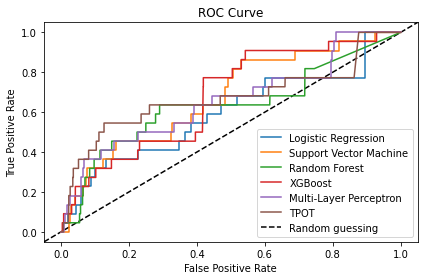

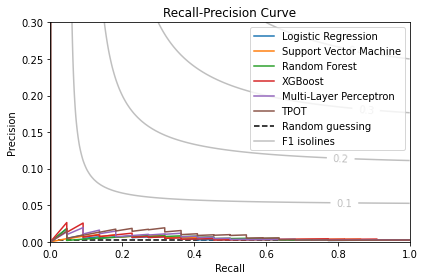

In [358]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    fitted_pipelines, X_train, X_test, y_train, y_test, save=True, figsize=(6,4), ylim=[0,.3])

In [ ]:
from sklearn.model_selection import cross_val_score
y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
res = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=tscv, n_jobs=5)
res, res.mean(), res.std()

In [ ]:
for ix_train, ix_val in tscv.split(X_train, y_train):
    print(f'{ix_train=}, {ix_val=}')
    print(f'{y_train[ix_train].sum()=}, {y_train[ix_val].sum()=}')
    pipeline.fit(X_train[ix_train, :], y_train[ix_train])

    y_score = pipeline.predict_proba(X_train[ix_val, :])[:,1]
    print('ROC AUC:', metrics.roc_auc_score(y_train[ix_val], y_score))
    print('AVG PREC:', metrics.average_precision_score(y_train[ix_val], y_score))
    plot_roc_curve(pipeline, X_train[ix_val, :], y_train[ix_val])
    plot_precision_recall_curve_with_f1(pipeline,  X_train[ix_val, :], y_train[ix_val])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_score = pipeline.predict_proba(X_train)[:,1]
metrics.roc_auc_score(y_train, y_score), metrics.average_precision_score(y_train, y_score)

In [ ]:
plot_roc_curve(pipeline, X_train, y_train)

In [ ]:
plot_precision_recall_curve_with_f1(pipeline, X_train, y_train)

In [ ]:
y_score = pipeline.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_score), metrics.average_precision_score(y_test, y_score)

In [ ]:
plot_roc_curve(pipeline, X_test, y_test)

In [ ]:
plot_precision_recall_curve_with_f1(pipeline, X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.boxplot(results['mean_test_score'])

In [ ]:
make_directory('experiments/plots')

In [ ]:
def fit_best_model(model, data, feature_type, target, scoring, X_train, y_train):
    print(model)
    pipeline, best_params, best_result = get_pipeline(model, data, feature_type, target, scoring)
    print(best_params)
    pipeline.fit(X_train, y_train)
    return pipeline

def fit_all_models(target, data, feature_type, scoring):
    X, y, features = data_map[feature_type][data](target)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

    fitted_pipelines = []
    for model in models:
        try:
            pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)
            fitted_pipelines.append((model, pipeline))
        except Exception as e:
            print(e)

    return fitted_pipelines, X_train, X_test, y_train, y_test
    

In [ ]:
target = 'performance' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision

## Performance versus General Bugs

In [236]:
def print_classification_report_at_threshold(clf, X, y, threshold):
    y_score = get_y_score(clf, X)
    y_pred = y_score >= threshold
    print(f'{threshold=}')
    report = metrics.classification_report(y, y_pred)
    print(report)
    roc_auc = metrics.roc_auc_score(y, y_score)
    average_precision = metrics.average_precision_score(y, y_score)
    print(f'{roc_auc=} {average_precision=}')

In [230]:
def fit_best_model(model, data, feature_type, target, scoring, X_train, y_train):
    print(model)
    pipeline, best_params, best_result = get_pipeline(data, feature_type, target, scoring, model)
    print(best_params)
    pipeline.fit(X_train, y_train)
    return pipeline

In [228]:
import shap
def plot_important_features(clf, X, feature_names, max_display=10):
    explainer = shap.Explainer(clf, X, feature_names=feature_names)
    print(explainer)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=max_display, feature_names=feature_names)
    plt.show()

In [ ]:
data = 'bugbug_buglevel'
scoring = 'average_precision'
feature_type = 'traditional'
model = 'lr'

target = 'performance'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

perf_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

In [ ]:
X_train_scaled = perf_pipeline['scaler'].transform(X_train)
perf_model = perf_pipeline['model']

plot_important_features(perf_model, X_train_scaled, features.columns, max_display=15)

In [ ]:
plot_precision_recall_curve_with_f1(perf_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(perf_pipeline, X_train, y_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_test, t)

y_score = get_y_score(perf_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [ ]:
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

In [ ]:
X_train_scaled = reg_pipeline['scaler'].transform(X_train)
reg_model = reg_pipeline['model']

plot_important_features(reg_model, X_train_scaled, features.columns, max_display=15)

In [ ]:
plot_precision_recall_curve_with_f1(reg_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_test, t)

y_score = get_y_score(reg_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [ ]:
data = 'bugbug_buglevel'
scoring = 'average_precision'
feature_type = 'bow'
model = 'lr'

target = 'performance'

X, y, features_names = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

perf_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

In [ ]:
perf_model = perf_pipeline['model']
plot_important_features(perf_model, X_test, features_names, max_display=15)

In [ ]:
plot_precision_recall_curve_with_f1(perf_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(perf_pipeline, X_train, y_train)
print_classification_report_at_threshold(perf_pipeline, X_test, y_test, t)

y_score = get_y_score(perf_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

In [ ]:
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

In [ ]:
reg_model = reg_pipeline['model']
plot_important_features(reg_model, X_test, features_names, max_display=15)

In [ ]:
plot_precision_recall_curve_with_f1(reg_pipeline, X_test, y_test)
t, f1 = get_best_f1_threshold(reg_pipeline, X_train, y_train)
print_classification_report_at_threshold(reg_pipeline, X_test, y_test, t)

y_score = get_y_score(reg_pipeline, X_test)
p = metrics.precision_score(y_test, y_score >= t)
p / y_test.mean()

### Predict Perf on Regression Model

In [255]:
data = 'bugbug_buglevel'
scoring = 'average_precision'
feature_type = 'traditional'
model = 'xgb'
target = 'regression'

X, y, features = data_map[feature_type][data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

reg_pipeline = fit_best_model(model, data, feature_type, target, scoring, X_train, y_train)

regression: 14287 positive 21.03% - negative 53634 78.97%
X.shape=(67921, 302)

xgb
{'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=1.0,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=1, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=65, n_jobs=4, num_parallel_tree=None, predictor=None,
              random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None), 'model__gamma': 1.0, 'model__max_delta_step': 1, 'model__max_depth': 3, 'model__min_child_weight': 5, 'model__n_estimators': 65, 'sampler': None}


In [256]:

X_perf, y_perf, features = data_map[feature_type][data]('performance')
X_perf_train, X_perf_test, y_perf_train, y_perf_test = train_test_split(X_perf, y_perf, test_size=0.1, shuffle=False)
perf_pipeline = fit_best_model('lr', data, feature_type, 'performance', scoring, X_perf_train, y_perf_train)

performance: 1880 positive 2.77% - negative 66041 97.23%
X.shape=(67921, 302)

lr
{'model': LogisticRegression(C=0.0338130774892353, random_state=0, solver='saga'), 'model__C': 0.0338130774892353, 'model__penalty': 'l2', 'sampler': SMOTE(random_state=0)}


invalid value encountered in true_divide
The following kwargs were not used by contour: 'label'


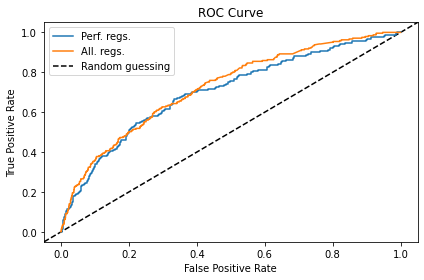

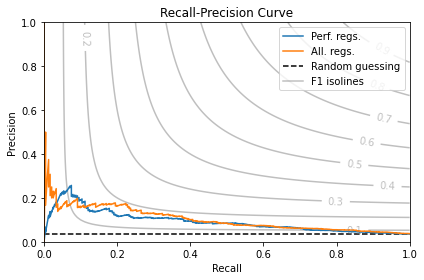

In [257]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('Trained on performance regressions', perf_pipeline), ('Trained on all reggressions', reg_pipeline)], X_train, X_test, X_perf_test, y_perf_test, save=False, figsize=(6,4), ylim=[0,1.])

invalid value encountered in true_divide
The following kwargs were not used by contour: 'label'


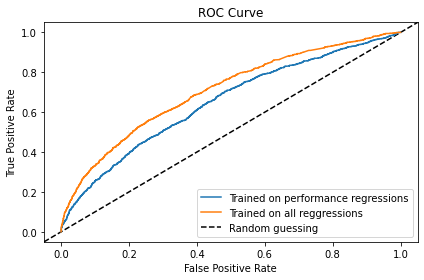

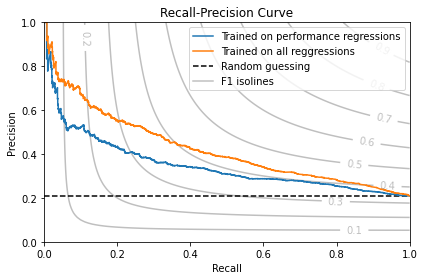

In [259]:
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring,
    [('Trained on performance regressions', perf_pipeline), ('Trained on all reggressions', reg_pipeline)], X_train, X_test, X_test, y_test, save=False, figsize=(6,4), ylim=[0,1.])

## Sampling

In [276]:
scoring = 'average_precision'
all_sampler_ranks = []
for (data, target) in [('fixed_defect_szz', 'performance'), ('bugbug_buglevel', 'performance')]: #('bugbug_buglevel', 'regression')
    for feature_type in ['traditional', 'bow']:
        for model in models:
            try:
                results = get_results(data, feature_type, target, scoring, model)
                results = results.replace({
                    None: 'No sampling',
                    'RandomOverSampler(random_state=0)': 'Random Over-Sampling',
                    'RandomUnderSampler(random_state=0)': 'Random Under-Sampling',
                    'SMOTE(random_state=0)': 'SMOTE'
                    })
                sampler_ranks = results.groupby('param_sampler')[['mean_test_score']].max().sort_values('mean_test_score', ascending=False)
                sampler_ranks['rank'] = np.arange(1,5)
                sampler_ranks['model'] = np.full(4, model)
                all_sampler_ranks.append(sampler_ranks)
            except FileNotFoundError:
                pass
all_sampler_ranks = pd.concat(all_sampler_ranks)
all_sampler_ranks

,mean_test_score,rank,model
param_sampler,,,
No sampling,0.0304,1,lr
Random Over-Sampling,0.0294,2,lr
SMOTE,0.0287,3,lr
Random Under-Sampling,0.0270,4,lr
No sampling,0.0365,1,svm
...,...,...,...
SMOTE,0.1133,4,rf
No sampling,0.1358,1,xgb
Random Under-Sampling,0.1108,2,xgb


In [277]:
t = all_sampler_ranks.groupby('param_sampler')[['rank']].mean().sort_values('rank', ascending=True)
t.index.name = 'Sampling Method'
t = t.rename({'rank': 'Average Rank'}, axis=1)
t

,Average Rank
Sampling Method,
No sampling,1.8889
Random Over-Sampling,2.2222
Random Under-Sampling,2.8889
SMOTE,3.0000


In [278]:
print(t.to_latex())

\begin{tabular}{lr}
\toprule
{} &  Average Rank \\
Sampling Method       &               \\
\midrule
No sampling           &        1.8889 \\
Random Over-Sampling  &        2.2222 \\
Random Under-Sampling &        2.8889 \\
SMOTE                 &        3.0000 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [279]:
scoring = 'average_precision'
best_sampler = []
for (data, target) in [('fixed_defect_szz', 'performance'), ('bugbug_buglevel', 'performance'), ('bugbug_buglevel', 'regression')]:
    for feature_type in ['traditional', 'bow']:
        for model in models:
            try:
                results = get_results(data, feature_type, target, scoring, model)
                results = results.replace({
                    None: 'No sampling',
                    'RandomOverSampler(random_state=0)': 'Over-Sampling',
                    'RandomUnderSampler(random_state=0)': 'Under-Sampling',
                    'SMOTE(random_state=0)': 'SMOTE'
                    })
                best_sampler.append({
                    'Data': data,
                    'Feature Type': feature_type,
                    'Target': target,
                    'Model': model_names[model],
                    'Sampling':results.iloc[0]['param_sampler'],
                    'AP (val.)': results.iloc[0]['mean_test_score']
                    })
            except FileNotFoundError:
                pass

best_sampler = pd.DataFrame(best_sampler)
best_sampler = best_sampler.replace({
    'fixed_defect_szz': 'SZZ',
    'bugbug_buglevel': 'bugbug'
})
best_sampler = best_sampler.replace({
    'performance': 'perf. regressions',
    'regression': 'all regressions'
})
best_sampler.set_index(pd.MultiIndex.from_frame(best_sampler[['Data', 'Target', 'Feature Type']]), inplace=True)
best_sampler = best_sampler.drop(['Data', 'Target', 'Feature Type'], axis=1)
best_sampler

Model        Sampling  \
Data   Target            Feature Type                                           
SZZ    perf. regressions traditional      Logistic Regression     No sampling   
                         traditional   Support Vector Machine     No sampling   
                         traditional            Random Forest   Over-Sampling   
                         traditional                  XGBoost   Over-Sampling   
                         traditional   Multi-Layer Perceptron     No sampling   
                         bow              Logistic Regression     No sampling   
                         bow           Support Vector Machine   Over-Sampling   
                         bow                    Random Forest     No sampling   
                         bow                          XGBoost     No sampling   
bugbug perf. regressions traditional      Logistic Regression           SMOTE   
                         traditional   Support Vector Machine           SMOTE   
                         traditional            Random Forest   Over-Sampling   
                         traditional                  XGBoost     No sampling   
                         traditional   Multi-Layer Perceptron           SMOTE   
                         bow              Logistic Regression     No sampling   
                         bow           Support Vector Machine  Under-Sampling   
                         bow                    Random Forest  Under-Sampling   
                         bow                          XGBoost     No sampling   
       all regressions   traditional      Logistic Regression   Over-Sampling   
                         traditional   Support Vector Machine   Over-Sampling   
                         traditional            Random Forest     No sampling   
                         traditional                  XGBoost     No sampling   
                         traditional   Multi-Layer Perceptron     No sampling   
                         bow              Logistic Regression     No sampling   
                         bow           Support Vector Machine   Over-Sampling   
                         bow                    Random Forest     No sampling   
                         bow                          XGBoost     No sampling   

                                       AP (val.)  
Data   Target            Feature Type             
SZZ    perf. regressions traditional      0.0304  
                         traditional      0.0365  
                         traditional      0.0528  
                         traditional      0.0590  
                         traditional      0.0375  
                         bow              0.0670  
                         bow              0.0563  
                         bow              0.0627  
                         bow              0.0765  
bugbug perf. regressions traditional      0.0767  
                         traditional      0.0804  
                         traditional      0.1055  
                         traditional      0.1088  
                         traditional      0.0869  
                         bow              0.1249  
                         bow              0.1181  
                         bow              0.1343  
                         bow              0.1358  
       all regressions   traditional      0.3729  
                         traditional      0.3836  
                         traditional      0.4237  
                         traditional      0.4236  
                         traditional      0.3875  
                         bow              0.3753  
                         bow              0.3666  
                         bow              0.4155  
                         bow              0.4027

In [280]:
print(best_sampler.to_latex(index=True))

\begin{tabular}{lllllr}
\toprule
       &                 &     &                   Model &        Sampling &  AP (val.) \\
Data & Target & Feature Type &                         &                 &            \\
\midrule
SZZ & perf. regressions & traditional &     Logistic Regression &     No sampling &     0.0304 \\
       &                 & traditional &  Support Vector Machine &     No sampling &     0.0365 \\
       &                 & traditional &           Random Forest &   Over-Sampling &     0.0528 \\
       &                 & traditional &                 XGBoost &   Over-Sampling &     0.0590 \\
       &                 & traditional &  Multi-Layer Perceptron &     No sampling &     0.0375 \\
       &                 & bow &     Logistic Regression &     No sampling &     0.0670 \\
       &                 & bow &  Support Vector Machine &   Over-Sampling &     0.0563 \\
       &                 & bow &           Random Forest &     No sampling &     0.0627 \\
       &   

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [260]:
best_sampler = []

scoring = 'average_precision'
for config, evaluations in evaluations_by_config.items():
    ws = config.split('_')
    feature_type = ws.pop()
    target = ws.pop()
    data = '_'.join(ws)

    amax = np.argmax([evaluation['test']['regression']['f1'] for evaluation in evaluations])
    evaluation = evaluations[amax]

    sampler = None
    if evaluation['model'] == 'tpot':
        sampler = None
    elif evaluation['best_params']:
        sampler = evaluation['best_params']['sampler']

    best_sampler.append({
        'Data': data,
        'Target': target,
        'Feature Type': feature_type,
        'Model':  model_names[evaluation['model']],
        'recall': evaluation['test']['regression']['recall'],
        'precision': evaluation['test']['regression']['precision'],
        'F1': evaluation['test']['regression']['f1'],
        'Sampling Method': str(sampler)
        })

best_sampler = pd.DataFrame(best_sampler)
best_sampler = best_sampler.replace({
                    'None': 'No sampling',
                    'RandomOverSampler(random_state=0)': 'Random Over-Sampling',
                    'RandomUnderSampler(random_state=0)': 'Random Under-Sampling',
                    'SMOTE(random_state=0)': 'SMOTE'
                    })

best_sampler = best_sampler.replace({
    'fixed_defect_szz': 'SZZ',
    'bugbug_buglevel': 'bugbug'
})
best_sampler = best_sampler.replace({
    'performance': 'perf. regressions',
    'regression': 'all regressions'
})

best_sampler.set_index(pd.MultiIndex.from_frame(best_sampler[['Data', 'Target', 'Feature Type']]), inplace=True)
best_sampler = best_sampler.drop(['Data', 'Target', 'Feature Type'], axis=1)

best_sampler    

Model  recall  \
Data   Target            Feature Type                                   
SZZ    perf. regressions traditional   Multi-Layer Perceptron  0.0909   
                         bow           Support Vector Machine  0.1818   
bugbug perf. regressions traditional      Logistic Regression  0.2946   
                         bow              Logistic Regression  0.1535   
       all regressions   traditional                  XGBoost  0.5275   
                         bow                          XGBoost  0.4062   

                                       precision     F1       Sampling Method  
Data   Target            Feature Type                                          
SZZ    perf. regressions traditional      0.0177 0.0296           No sampling  
                         bow              0.0288 0.0497  Random Over-Sampling  
bugbug perf. regressions traditional      0.1084 0.1585                 SMOTE  
                         bow              0.2022 0.1745           No sampling  
       all regressions   traditional      0.3770 0.4397           No sampling  
                         bow              0.4168 0.4114           No sampling

In [275]:
print(best_sampler.to_latex(index=True))

\begin{tabular}{llllrrrl}
\toprule
       &                 &     &                   Model &  recall &  precision &     F1 &       Sampling Method \\
Data & Target & Feature Type &                         &         &            &        &                       \\
\midrule
SZZ & perf. regressions & traditional &  Multi-Layer Perceptron &  0.0909 &     0.0177 & 0.0296 &           No sampling \\
       &                 & bow &  Support Vector Machine &  0.1818 &     0.0288 & 0.0497 &  Random Over-Sampling \\
bugbug & perf. regressions & traditional &     Logistic Regression &  0.2946 &     0.1084 & 0.1585 &                 SMOTE \\
       &                 & bow &     Logistic Regression &  0.1535 &     0.2022 & 0.1745 &           No sampling \\
       & all regressions & traditional &                 XGBoost &  0.5275 &     0.3770 & 0.4397 &           No sampling \\
       &                 & bow &                 XGBoost &  0.4062 &     0.4168 & 0.4114 &           No sampling \\
\bott

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


## Model Parameters

In [221]:
scoring = 'average_precision'
best_params_per_model = {}

for model in models:
    best_params_model = []
    for (data, target) in [('fixed_defect_szz', 'performance'), ('bugbug_buglevel', 'performance'), ('bugbug_buglevel', 'regression')]:
        for feature_type in ['traditional', 'bow']:
                try:
                    results = get_results(data, feature_type, target, scoring, model)
                    params = get_params(results)
                    best_params = get_best_params(model, params)
                    del best_params['model']
                    best_params['sampler'] = str(best_params['sampler'])

                    index = {  
                        'Model': model_names[model],
                        'Data': data, 
                        'Feature Type': feature_type,
                        'Target': target
                        }
                    best_params_model.append({**index, **best_params})
                except FileNotFoundError:
                    pass
    if len(best_params_model) == 0:
        continue

    df = pd.DataFrame(best_params_model)
    df = df.replace({
                    'None': 'No sampling',
                    'RandomOverSampler(random_state=0)': 'Random Over-Sampling',
                    'RandomUnderSampler(random_state=0)': 'Random Under-Sampling',
                    'SMOTE(random_state=0)': 'SMOTE'
                    })

    df = df.replace({
        'fixed_defect_szz': 'SZZ',
        'bugbug_buglevel': 'bugbug'
    })
    df = df.replace({
        'performance': 'perf. regressions',
        'regression': 'all regressions'
    })
    df.set_index(pd.MultiIndex.from_frame(df[['Data','Target', 'Feature Type',]]), inplace=True)
    df = df.drop(['Model','Data','Feature Type','Target'], axis=1)
    def rename_f(c):
        if 'model' in c:
            c = c[7:]
        if 'kernel' in c:
            c = c[8:]
        return c.capitalize()

    df = df.rename(rename_f, axis=1)
    best_params_per_model[model] = df
                

In [226]:
print(best_params_per_model['svm'].to_latex())

\begin{tabular}{lllrlrl}
\toprule
       &                 &     &  Degree &  Kernel &        C &                Sampler \\
Data & Target & Feature Type &         &         &          &                        \\
\midrule
SZZ & perf. regressions & traditional &       5 &    poly &  20.1519 &            No sampling \\
       &                 & bow &       3 &    poly & 593.4792 &   Random Over-Sampling \\
bugbug & perf. regressions & traditional &       5 &     rbf &   1.5037 &                  SMOTE \\
       &                 & bow &       5 &  linear &   0.1330 &  Random Under-Sampling \\
       & all regressions & traditional &       5 &     rbf & 184.5465 &   Random Over-Sampling \\
       &                 & bow &       5 &    poly &  97.9066 &   Random Over-Sampling \\
\bottomrule
\end{tabular}



/tmp/ipykernel_5592/1788900139.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(best_params_per_model['svm'].to_latex())
